# Case Study and Implementation

In [ ]:
import pandas as pd
import os
import shutil
from google.colab import drive
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [ ]:
import pandas as pd
import os
import shutil
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
dataset_path = '/content/drive/MyDrive/ISIC-images'
image_dir = os.path.join(dataset_path)
metadata_file = os.path.join(dataset_path, 'metadata.csv')
output_dir = os.path.join(dataset_path, 'organized_images')

# Create output directories
os.makedirs(os.path.join(output_dir, 'malignant'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'benign'), exist_ok=True)

# Read metadata
df = pd.read_csv(metadata_file)

# Function to determine if an image is malignant or benign
def get_label(row):
    if row['diagnosis_1'] == 'Malignant':
        return 'malignant'
    elif row['diagnosis_1'] == 'Benign':
        return 'benign'
    else:
        return None

# Sort images into subfolders
for idx, row in df.iterrows():
    image_name = row['isic_id'] + '.jpg'
    src_path = os.path.join(image_dir, image_name)
    label = get_label(row)
    if label and os.path.exists(src_path):
        dest_path = os.path.join(output_dir, label, image_name)
        shutil.copy(src_path, dest_path)

print("Images organized into malignant/ and benign/ subfolders.")

Mounted at /content/drive
Images organized into malignant/ and benign/ subfolders.


## Load Data (Separate into: Train, Validation, and Test Sets)

In [ ]:
import os
import random
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing and splitting
preprocessed_dir = '/content/drive/MyDrive/ISIC-images/preprocessed_split'
target_size = (172, 251)  # Height, Width
test_size = 0.15
val_size = 0.15
random_seed = 42

# Create output folders
for split in ['train', 'val', 'test']:
    for label in ['malignant', 'benign']:
        os.makedirs(os.path.join(preprocessed_dir, split, label), exist_ok=True)

# Collect image paths and labels
image_paths = []
labels = []
for label in ['malignant', 'benign']:
    folder = os.path.join(output_dir, label)
    for fname in os.listdir(folder):
        if fname.lower().endswith('.jpg'):
            image_paths.append(os.path.join(folder, fname))
            labels.append(label)

# Split dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=test_size, stratify=labels, random_state=random_seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size / (1 - test_size), stratify=y_train_val, random_state=random_seed
)

# Function to preprocess and save images
def preprocess_and_save(images, labels, split_name):
    for path, label in zip(images, labels):
        img = Image.open(path).convert('RGB')
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0  # Normalize
        img_norm = Image.fromarray((img_array * 255).astype(np.uint8))
        filename = os.path.basename(path)
        save_path = os.path.join(preprocessed_dir, split_name, label, filename)
        img_norm.save(save_path)

# Preprocess and save
preprocess_and_save(X_train, y_train, 'train')
preprocess_and_save(X_val, y_val, 'val')
preprocess_and_save(X_test, y_test, 'test')

print("Preprocessing complete: resized, normalized, and split into train/val/test.")

# Data generators
batch_size = 16
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'train'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'val'),
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_directory(
    os.path.join(preprocessed_dir, 'test'),
    target_size=target_size,
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Evaluate on test set using the generator
y_true = test_gen.classes
test_gen.reset()
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

print("\nEvaluation Metrics on Test Set:")
print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall   : {recall_score(y_true, y_pred):.4f}")


Preprocessing complete: resized, normalized, and split into train/val/test.
Found 137 images belonging to 2 classes.
Found 54 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


# SECTION 1: Model Architecture

## Task: Define a function that creates models without and with specified optimization techniques

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import warnings
import numpy as np

def define_model(optimization: str, regularization_datatype, early_stopping: bool, dropout: float, learning_rate: float,
                 train_gen=None, val_gen=None, compute_metrics=False, model_save_path=None, **kwargs):
    """
    Define and optionally train a neural network model for binary classification.

    Parameters:
    - optimization: str, optimizer type ('adam' or 'rmsprop')
    - regularization_datatype: Keras regularizer (e.g., l2(0.01) or None)
    - early_stopping: bool, whether to fit with EarlyStopping callback
    - dropout: float, dropout rate (0.0 to 1.0)
    - learning_rate: float, optimizer learning rate
    - train_gen: Keras generator for training
    - val_gen: Keras generator for validation
    - compute_metrics: bool, whether to print evaluation metrics
    - model_save_path: str, path to save the trained model (optional)
    - **kwargs: catches additional parameters

    Returns:
    - Tuple of (compiled Keras Sequential model, training history or None)
    """
    if kwargs:
        warnings.warn(f"Unused parameters passed to define_model: {kwargs}", UserWarning)

    if early_stopping and (train_gen is None or val_gen is None):
        raise ValueError("train_gen and val_gen must be provided when early_stopping=True")

    model = Sequential()
    model.add(Flatten(input_shape=(172, 251, 3)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularization_datatype))
    model.add(Dense(1, activation='sigmoid'))

    if optimization.lower() == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimization.lower() == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimization}")

    model.compile(optimizer=optimizer_instance, loss='binary_crossentropy', metrics=['accuracy'])

    history = None
    if early_stopping:
        callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
        history = model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks, verbose=1)

    if compute_metrics and val_gen:
        y_true = val_gen.classes
        y_pred_probs = model.predict(val_gen)
        y_pred = (y_pred_probs > 0.5).astype(int).flatten()

        print("\nEvaluation Metrics on Validation Set:")
        print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
        print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
        print(f"Precision: {precision_score(y_true, y_pred):.4f}")
        print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
        print(f"ROC AUC  : {roc_auc_score(y_true, y_pred_probs):.4f}")

    if model_save_path:
        model.save(model_save_path)
        print(f"Model saved to {model_save_path}")

    return model, history

## Task: Print out the Final Model Accuracy and plot the Loss curve

In [ ]:
import matplotlib.pyplot as plt

def loss_curve_plot(history, title):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def print_final_accuracy(history, title):
    print(f"{title} Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"{title} Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

# SECTION 2: Optimization and Regularization Combinations

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Evaluation Metrics on Validation Set:
Accuracy : 0.3333
F1 Score : 0.1429
Precision: 0.6000


Recall   : 0.0811
ROC AUC  : 0.5374
Model saved to /content/drive/MyDrive/saved_models/model1.h5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.5604 - loss: 28.2896 - val_accuracy: 0.6852 - val_loss: 2.7231
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.6207 - loss: 3.7020 - val_accuracy: 0.7222 - val_loss: 0.9763
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.5697 - loss: 6.1387 - val_accuracy: 0.6667 - val_loss: 2.9993
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6622 - loss: 2.8873 - val_accuracy: 0.7593 - val_loss: 1.3999
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 0.7502 - loss: 2.2191 - val_accuracy: 0.7407 - val_loss: 1.8694
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.7965 - loss: 2.1379 - val_accuracy: 0.7222 - val_loss: 1.5551
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - accuracy: 0.6817 - loss: 1.9924 - val_accuracy: 0.6852 - val_loss: 6.4267
Epoch 8/50
9/9 ━━━━━

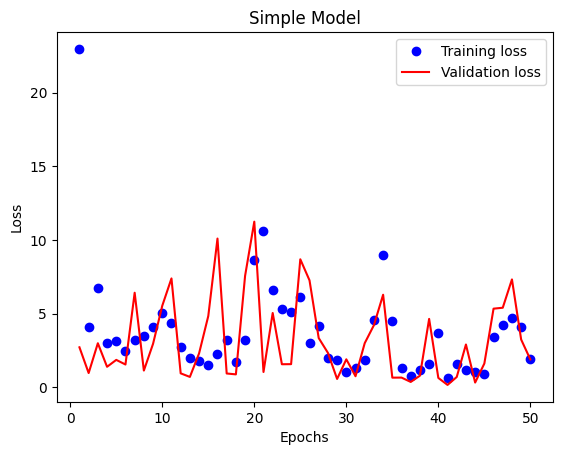

Simple Model Final Training Accuracy: 0.7664
Simple Model Final Validation Accuracy: 0.7778
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


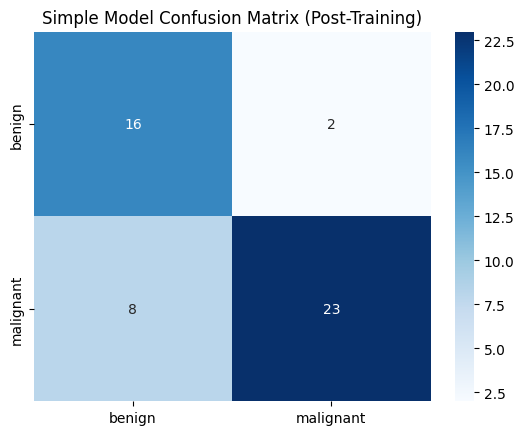

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step



Evaluation Metrics on Validation Set:
Accuracy : 0.6852
F1 Score : 0.8132
Precision: 0.6852
Recall   : 1.0000
ROC AUC  : 0.4658
Model saved to /content/drive/MyDrive/saved_models/model2.h5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - accuracy: 0.5176 - loss: 27.3761 - val_accuracy: 0.3148 - val_loss: 2.4138
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.3963 - loss: 7.8209 - val_accuracy: 0.6852 - val_loss: 7.0618
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.6945 - loss: 5.0353 - val_accuracy: 0.6852 - val_loss: 5.0339
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.5045 - loss: 4.6898 - val_accuracy: 0.5741 - val_loss: 3.4145
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.7167 - loss: 3.0012 - val_accuracy: 0.6852 - val_loss: 3.5950
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.6407 - loss: 3.3313 - val_accuracy: 0.7407 - val_loss: 2.5049
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 317ms/step - a

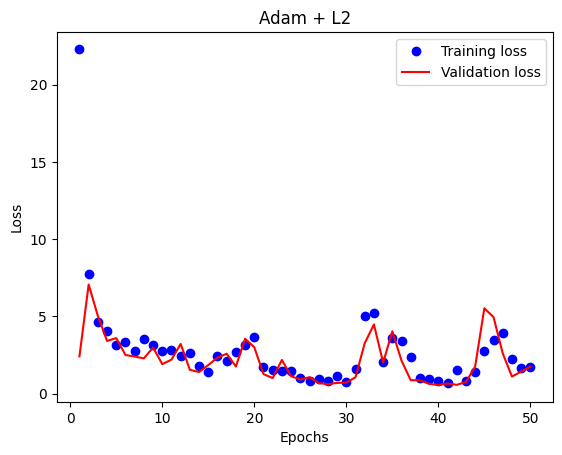

Adam + L2 Final Training Accuracy: 0.6788
Adam + L2 Final Validation Accuracy: 0.6111
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


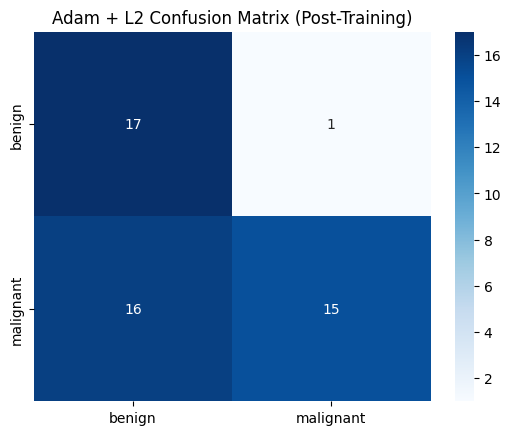

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step



Evaluation Metrics on Validation Set:
Accuracy : 0.4074
F1 Score : 0.4839
Precision: 0.6000
Recall   : 0.4054
ROC AUC  : 0.4277
Model saved to /content/drive/MyDrive/saved_models/model3.h5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.6025 - loss: 59.3313 - val_accuracy: 0.3148 - val_loss: 15.0074
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.4979 - loss: 6.1394 - val_accuracy: 0.6852 - val_loss: 0.6915
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.6697 - loss: 1.5533 - val_accuracy: 0.6852 - val_loss: 0.6909
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - accuracy: 0.6254 - loss: 0.6915 - val_accuracy: 0.6852 - val_loss: 0.6899
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.6146 - loss: 0.6910 - val_accuracy: 0.6852 - val_loss: 0.6887
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.6726 - loss: 0.6888 - val_accuracy: 0.6852 - val_loss: 0.6876
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - 

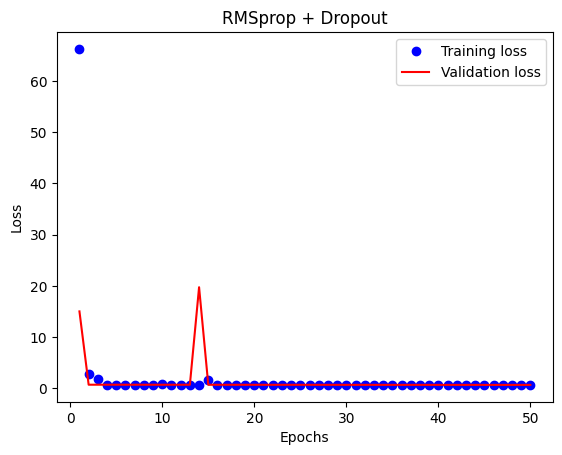

RMSprop + Dropout Final Training Accuracy: 0.6496
RMSprop + Dropout Final Validation Accuracy: 0.6852
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


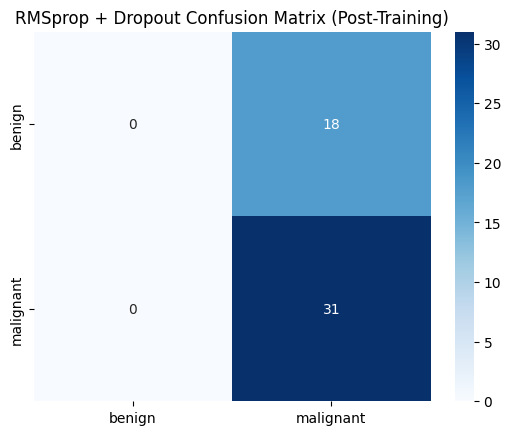

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - accuracy: 0.4979 - loss: 25.3682 - val_accuracy: 0.6852 - val_loss: 8.1933
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6786 - loss: 3.9350 - val_accuracy: 0.6852 - val_loss: 0.6284
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.6037 - loss: 0.6748 - val_accuracy: 0.7222 - val_loss: 0.5578
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - accuracy: 0.6858 - loss: 0.6483 - val_accuracy: 0.6852 - val_loss: 1.2286
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - accuracy: 0.6756 - loss: 0.9134 - val_accuracy: 0.5556 - val_loss: 0.8479
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - accuracy: 0.5690 - loss: 0.8088 - val_accuracy: 0.6852 - val_loss: 0.5249
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 210ms/step - accuracy: 0.6575 - loss: 0.5683 - val_accuracy: 0.7037 - val_loss: 0.5682
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.6551 - loss: 0.6754 - val_accuracy: 0.3519 - val_loss


Evaluation Metrics on Validation Set:
Accuracy : 0.5185
F1 Score : 0.6176
Precision: 0.6774
Recall   : 0.5676
ROC AUC  : 0.4849
Model saved to /content/drive/MyDrive/saved_models/model4.h5
Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6528 - loss: 0.8058

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.6532 - loss: 0.8132 - val_accuracy: 0.5556 - val_loss: 1.0705
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 212ms/step - accuracy: 0.6088 - loss: 0.9299 - val_accuracy: 0.6852 - val_loss: 1.1543
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6810 - loss: 0.9259

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.6873 - loss: 0.9006 - val_accuracy: 0.6852 - val_loss: 0.8482
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.6693 - loss: 0.9804 - val_accuracy: 0.6852 - val_loss: 2.0064
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 313ms/step - accuracy: 0.6125 - loss: 1.4318 - val_accuracy: 0.6852 - val_loss: 0.8779
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.6846 - loss: 0.7085

9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 531ms/step - accuracy: 0.6891 - loss: 0.6948 - val_accuracy: 0.7963 - val_loss: 0.4416
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.8027 - loss: 0.3966 - val_accuracy: 0.6481 - val_loss: 0.7225
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.7130 - loss: 0.6024

9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 901ms/step - accuracy: 0.7132 - loss: 0.5971 - val_accuracy: 0.8519 - val_loss: 0.3418
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.7326 - loss: 0.5862 - val_accuracy: 0.8148 - val_loss: 0.3771
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.8048 - loss: 0.4286 - val_accuracy: 0.7407 - val_loss: 0.4009
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.7881 - loss: 0.4075 - val_accuracy: 0.7778 - val_loss: 0.3732
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8124 - loss: 0.4151

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.8085 - loss: 0.4196 - val_accuracy: 0.8889 - val_loss: 0.3302
Epoch 13/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 277ms/step - accuracy: 0.7305 - loss: 0.5646 - val_accuracy: 0.8148 - val_loss: 0.3578
Epoch 14/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 425ms/step - accuracy: 0.7767 - loss: 0.4412 - val_accuracy: 0.7778 - val_loss: 0.4057
Epoch 15/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8333 - loss: 0.3548

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 226ms/step - accuracy: 0.8310 - loss: 0.3582 - val_accuracy: 0.9074 - val_loss: 0.3219
Epoch 16/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8048 - loss: 0.3720

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.8075 - loss: 0.3717 - val_accuracy: 0.8889 - val_loss: 0.3201
Epoch 17/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.8052 - loss: 0.3614 - val_accuracy: 0.7407 - val_loss: 0.4213
Epoch 18/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7561 - loss: 0.4949

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - accuracy: 0.7513 - loss: 0.5044 - val_accuracy: 0.9074 - val_loss: 0.3150
Epoch 19/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.7732 - loss: 0.4460 - val_accuracy: 0.7407 - val_loss: 0.4657
Epoch 20/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.7110 - loss: 0.5970 - val_accuracy: 0.7778 - val_loss: 0.3781
Epoch 21/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step - accuracy: 0.7893 - loss: 0.4703 - val_accuracy: 0.7037 - val_loss: 0.6445
Epoch 22/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.6606 - loss: 0.6553 - val_accuracy: 0.8519 - val_loss: 0.3319
Epoch 23/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - accuracy: 0.7648 - loss: 0.5423 - val_accuracy: 0.7407 - val_loss: 0.5216
Epoch 24/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7910 - loss: 0.3887

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - accuracy: 0.7893 - loss: 0.3893 - val_accuracy: 0.8889 - val_loss: 0.3044
Epoch 25/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.9092 - loss: 0.3152 - val_accuracy: 0.7037 - val_loss: 0.5252
Epoch 26/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - accuracy: 0.7027 - loss: 0.4521 - val_accuracy: 0.7778 - val_loss: 0.3950
Epoch 27/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8340 - loss: 0.3718

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.8309 - loss: 0.3736 - val_accuracy: 0.8889 - val_loss: 0.2917
Epoch 28/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - accuracy: 0.7792 - loss: 0.3993 - val_accuracy: 0.8704 - val_loss: 0.3001
Epoch 29/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.7712 - loss: 0.4730 - val_accuracy: 0.5741 - val_loss: 0.8774
Epoch 30/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.6380 - loss: 0.8866 - val_accuracy: 0.7037 - val_loss: 0.7995
Epoch 31/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 631ms/step - accuracy: 0.6599 - loss: 0.9435 - val_accuracy: 0.7222 - val_loss: 0.4707
Epoch 32/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.6906 - loss: 0.7147 - val_accuracy: 0.6852 - val_loss: 0.7911
Epoch 33/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.6651 - loss: 0.7641 - val_accuracy: 0.6852 - val_loss: 0.7829
Epoch 34/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step - accuracy: 0.7339 - loss: 0.6058 - val_accuracy: 0.8519 - val_loss: 0.3

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.8769 - loss: 0.3047 - val_accuracy: 0.9444 - val_loss: 0.2910
Epoch 38/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.8261 - loss: 0.3646 - val_accuracy: 0.7407 - val_loss: 0.3591
Epoch 39/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - accuracy: 0.8699 - loss: 0.3279 - val_accuracy: 0.9259 - val_loss: 0.2912
Epoch 40/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - accuracy: 0.8798 - loss: 0.2908 - val_accuracy: 0.7778 - val_loss: 0.3965
Epoch 41/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.8118 - loss: 0.3683 - val_accuracy: 0.7593 - val_loss: 0.4109
Epoch 42/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 416ms/step - accuracy: 0.6739 - loss: 0.5518 - val_accuracy: 0.7778 - val_loss: 0.4313
Epoch 43/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7735 - loss: 0.4016

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 286ms/step - accuracy: 0.7736 - loss: 0.4045 - val_accuracy: 0.9444 - val_loss: 0.2671
Epoch 44/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.8126 - loss: 0.3714 - val_accuracy: 0.8519 - val_loss: 0.3148
Epoch 45/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7830 - loss: 0.3783 - val_accuracy: 0.7593 - val_loss: 0.3717
Epoch 46/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step - accuracy: 0.8520 - loss: 0.3324 - val_accuracy: 0.7593 - val_loss: 0.4641
Epoch 47/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - accuracy: 0.6987 - loss: 0.5617 - val_accuracy: 0.7407 - val_loss: 0.4343
Epoch 48/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 434ms/step - accuracy: 0.8109 - loss: 0.3924 - val_accuracy: 0.7222 - val_loss: 0.5724
Epoch 49/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.7793 - loss: 0.4829 - val_accuracy: 0.8519 - val_loss: 0.3029
Epoch 50/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8422 - loss: 0.3119

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - accuracy: 0.8412 - loss: 0.3137 - val_accuracy: 0.9074 - val_loss: 0.2626


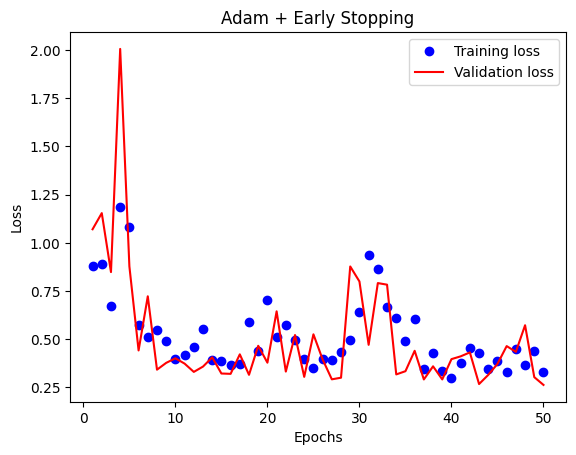

Adam + Early Stopping Final Training Accuracy: 0.8321
Adam + Early Stopping Final Validation Accuracy: 0.9074
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


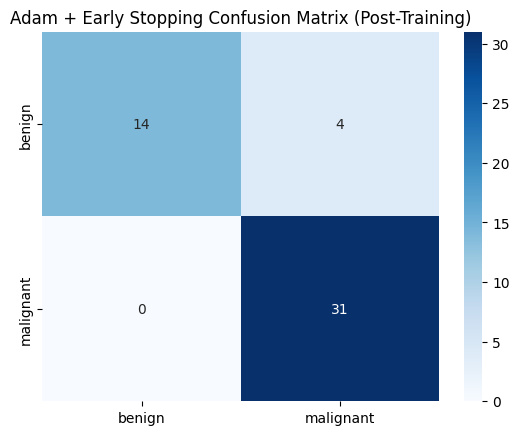

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.4179 - loss: 6.2408 - val_accuracy: 0.6852 - val_loss: 2.3718
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 215ms/step - accuracy: 0.6640 - loss: 2.3163 - val_accuracy: 0.3148 - val_loss: 1.9633
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 699ms/step - accuracy: 0.6049 - loss: 1.9085 - val_accuracy: 0.6481 - val_loss: 1.8617
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - accuracy: 0.5394 - loss: 1.8479 - val_accuracy: 0.6852 - val_loss: 1.8228
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.6263 - loss: 1.8685 - val_accuracy: 0.6852 - val_loss: 1.7952
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 353ms/step - accuracy: 0.7042 - loss: 1.7343 - val_accuracy: 0.6852 - val_loss: 1.6930
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.6774 - loss: 1.7766 - val_accuracy: 0.7407 - val_loss: 1.6776
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7136 - loss: 1.6542 - val_accuracy: 0.5556 - val_loss:


Evaluation Metrics on Validation Set:
Accuracy : 0.4074
F1 Score : 0.5152
Precision: 0.5862
Recall   : 0.4595
ROC AUC  : 0.4038
Model saved to /content/drive/MyDrive/saved_models/optimized_cnn_model_4.h5


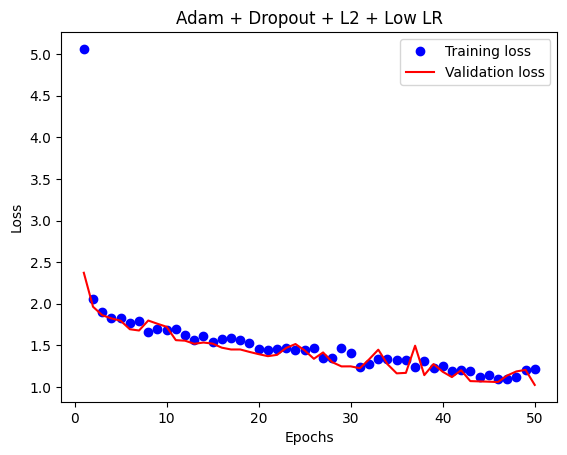

Adam + Dropout + L2 + Low LR Final Training Accuracy: 0.6642
Adam + Dropout + L2 + Low LR Final Validation Accuracy: 0.7778
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


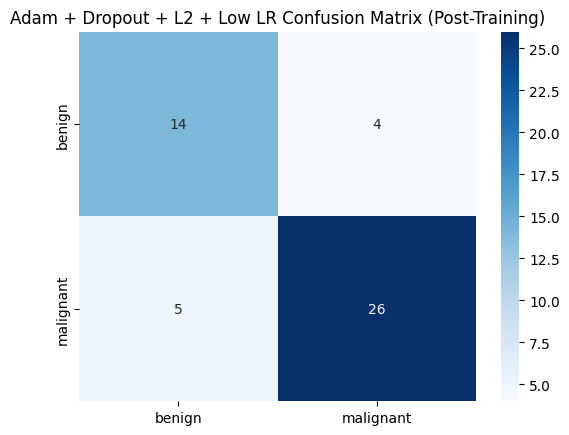

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

Simple Model Test Results:
              precision    recall  f1-score   support

      benign       0.67      0.89      0.76        18
   malignant       0.92      0.74      0.82        31

    accuracy                           0.80        49
   macro avg       0.79      0.82      0.79        49
weighted avg       0.83      0.80      0.80        49

ROC AUC: 0.9373


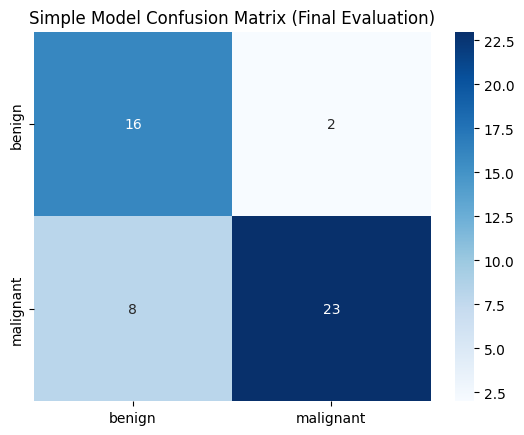

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step

Adam + L2 Test Results:
              precision    recall  f1-score   support

      benign       0.52      0.94      0.67        18
   malignant       0.94      0.48      0.64        31

    accuracy                           0.65        49
   macro avg       0.73      0.71      0.65        49
weighted avg       0.78      0.65      0.65        49

ROC AUC: 0.8763


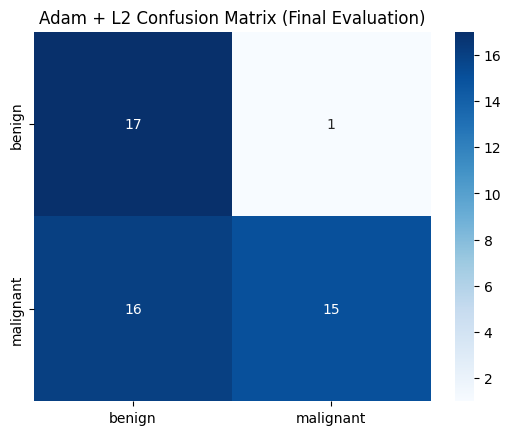

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

RMSprop + Dropout Test Results:
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00        18
   malignant       0.63      1.00      0.78        31

    accuracy                           0.63        49
   macro avg       0.32      0.50      0.39        49
weighted avg       0.40      0.63      0.49        49

ROC AUC: 0.5000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


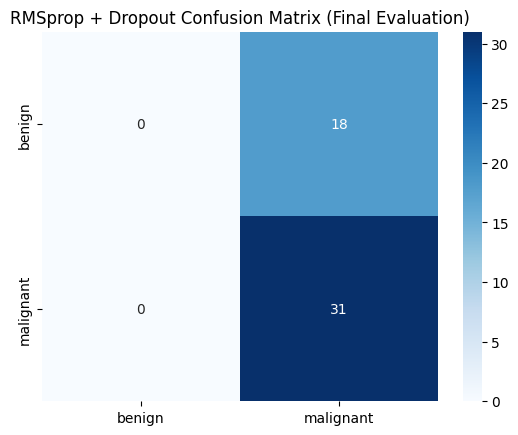

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Adam + Early Stopping Test Results:
              precision    recall  f1-score   support

      benign       1.00      0.78      0.88        18
   malignant       0.89      1.00      0.94        31

    accuracy                           0.92        49
   macro avg       0.94      0.89      0.91        49
weighted avg       0.93      0.92      0.92        49

ROC AUC: 0.9713


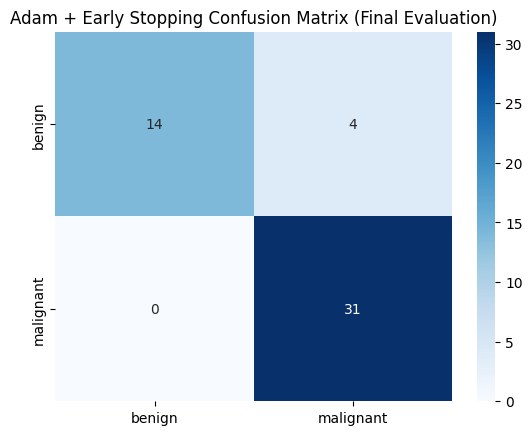

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

Adam + Dropout + L2 + Low LR Test Results:
              precision    recall  f1-score   support

      benign       0.74      0.78      0.76        18
   malignant       0.87      0.84      0.85        31

    accuracy                           0.82        49
   macro avg       0.80      0.81      0.80        49
weighted avg       0.82      0.82      0.82        49

ROC AUC: 0.8943


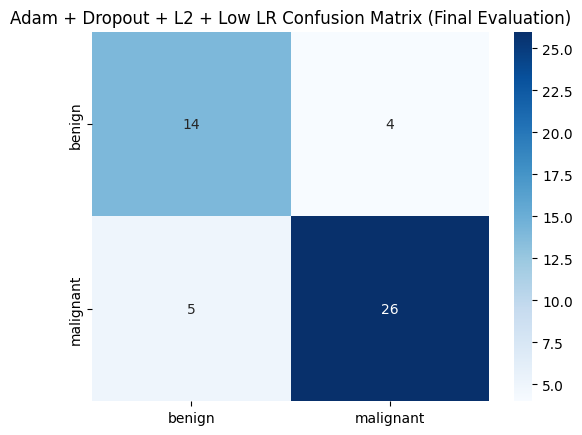

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint

# Stage 5: Train Neural Network Models
# Model 1: Simple Model (Instance 1)
model1, hist1 = define_model(
    optimization='adam', regularization_datatype=None, early_stopping=False, dropout=0.0, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model1.h5'
)
if hist1 is None:
    hist1 = model1.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1)
loss_curve_plot(hist1, "Simple Model")
print_final_accuracy(hist1, "Simple Model")

y_pred_prob1 = model1.predict(test_gen)
y_pred1 = (y_pred_prob1 > 0.5).astype(int).flatten()
y_true = test_gen.classes
cm1 = confusion_matrix(y_true, y_pred1)
plt.figure()
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Simple Model Confusion Matrix (Post-Training)")
plt.show()

# Model 2: Adam + L2 Regularization (Instance 2)
model2, hist2 = define_model(
    optimization='adam', regularization_datatype=l2(0.01), early_stopping=False, dropout=0.0, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model2.h5'
)
if hist2 is None:
    hist2 = model2.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1)
loss_curve_plot(hist2, "Adam + L2")
print_final_accuracy(hist2, "Adam + L2")

y_pred_prob2 = model2.predict(test_gen)
y_pred2 = (y_pred_prob2 > 0.5).astype(int).flatten()
cm2 = confusion_matrix(y_true, y_pred2)
plt.figure()
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + L2 Confusion Matrix (Post-Training)")
plt.show()

# Model 3: RMSprop + Dropout (Instance 3)
model3, hist3 = define_model(
    optimization='rmsprop', regularization_datatype=None, early_stopping=False, dropout=0.2, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model3.h5'
)
if hist3 is None:
    hist3 = model3.fit(train_gen, validation_data=val_gen, epochs=50, verbose=1)
loss_curve_plot(hist3, "RMSprop + Dropout")
print_final_accuracy(hist3, "RMSprop + Dropout")

y_pred_prob3 = model3.predict(test_gen)
y_pred3 = (y_pred_prob3 > 0.5).astype(int).flatten()
cm3 = confusion_matrix(y_true, y_pred3)
plt.figure()
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("RMSprop + Dropout Confusion Matrix (Post-Training)")
plt.show()

# Model 4: Adam + Early Stopping (Instance 4)
model4, hist4 = define_model(
    optimization='adam', regularization_datatype=None, early_stopping=True, dropout=0.0, learning_rate=0.001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/model4.h5'
)
checkpoint = ModelCheckpoint('/content/drive/MyDrive/saved_models/model4_best.h5',
                             monitor='val_loss', save_best_only=True)
if hist4 is None:
    hist4 = model4.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=10), checkpoint], verbose=1)
else:
    # Re-fit with checkpoint callback
    hist4 = model4.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=10), checkpoint], verbose=1)
loss_curve_plot(hist4, "Adam + Early Stopping")
print_final_accuracy(hist4, "Adam + Early Stopping")

y_pred_prob4 = model4.predict(test_gen)
y_pred4 = (y_pred_prob4 > 0.5).astype(int).flatten()
cm4 = confusion_matrix(y_true, y_pred4)
plt.figure()
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + Early Stopping Confusion Matrix (Post-Training)")
plt.show()

# Model 5: Adam + Dropout + L2 + Lower Learning Rate (Instance 5)
model5, hist5 = define_model(
    optimization='adam', regularization_datatype=l2(0.01), early_stopping=True, dropout=0.5, learning_rate=0.0001,
    train_gen=train_gen, val_gen=val_gen, compute_metrics=True, model_save_path='/content/drive/MyDrive/saved_models/optimized_cnn_model_4.h5'
)
if hist5 is None:
    hist5 = model5.fit(train_gen, validation_data=val_gen, epochs=50,
                       callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)
loss_curve_plot(hist5, "Adam + Dropout + L2 + Low LR")
print_final_accuracy(hist5, "Adam + Dropout + L2 + Low LR")

y_pred_prob5 = model5.predict(test_gen)
y_pred5 = (y_pred_prob5 > 0.5).astype(int).flatten()
cm5 = confusion_matrix(y_true, y_pred5)
plt.figure()
sns.heatmap(cm5, annot=True, fmt='d', cmap='Blues',
            xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title("Adam + Dropout + L2 + Low LR Confusion Matrix (Post-Training)")
plt.show()

# Final Evaluation
models = [model1, model2, model3, model4, model5]
titles = ["Simple Model", "Adam + L2", "RMSprop + Dropout", "Adam + Early Stopping", "Adam + Dropout + L2 + Low LR"]

for model, title in zip(models, titles):
    y_pred_prob = model.predict(test_gen)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    y_true = test_gen.classes

    print(f"\n{title} Test Results:")
    print(classification_report(y_true, y_pred, target_names=['benign', 'malignant']))
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred_prob):.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
    plt.title(f"{title} Confusion Matrix (Final Evaluation)")
    plt.show()

## Task: Make Predictions using the best saved model

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:13:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

XGBoost Classification Report (Test Data):
              precision    recall  f1-score   support

      benign       0.95      1.00      0.97        18
   malignant       1.00      0.97      0.98        31

    accuracy                           0.98        49
   macro avg       0.97      0.98      0.98        49
weighted avg       0.98      0.98      0.98        49

XGBoost ROC AUC: 0.9946


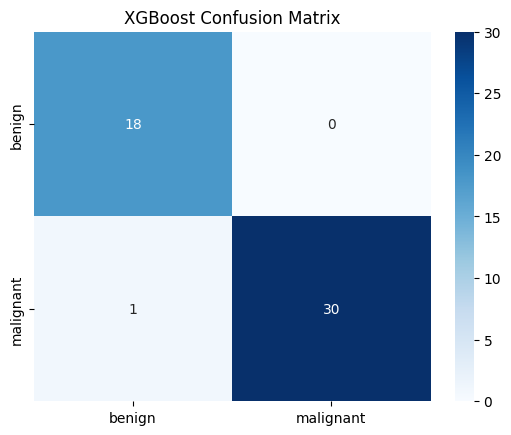

XGBoost model saved successfully.


In [ ]:
# Stage 6: XGBoost Model (Additional Comparison)
def load_data_from_folder(folder_path, target_size=(172, 251)):
    data = []
    labels = []
    for label in ['benign', 'malignant']:
        label_path = os.path.join(folder_path, label)
        for fname in os.listdir(label_path):
            if fname.endswith('.jpg'):
                img = Image.open(os.path.join(label_path, fname)).resize(target_size)
                data.append(np.array(img).flatten())
                labels.append(label)
    return np.array(data), np.array(labels)

X, y = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/train')
X_val, y_val = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/val')
X_test, y_test = load_data_from_folder('/content/drive/MyDrive/ISIC-images/preprocessed_split/test')

le = LabelEncoder()
y = le.fit_transform(y)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0]
}

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1)
grid.fit(X, y)

print(f"\nXGBoost Best Parameters: {grid.best_params_}")

best_xgb_model = grid.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

print("\nXGBoost Classification Report (Test Data):")
print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
print(f"XGBoost ROC AUC: {roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1]):.4f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure()
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("XGBoost Confusion Matrix")
plt.show()

best_xgb_model.save_model('/content/drive/MyDrive/saved_models/optimized_xgb_model.json')
print("XGBoost model saved successfully.")

In [ ]:
# Stage 7: Make Predictions with Best Neural Network Model
def make_predictions(model_path, X):
    model = load_model(model_path)
    prob = model.predict(X)
    predictions = (prob > 0.5).astype(int).flatten()
    return predictions

best_model_path = '/content/drive/MyDrive/saved_models/best_model.h5'
predictions = make_predictions(best_model_path, test_gen)

filenames = test_gen.filenames
for i in range(min(5, len(predictions))):
    print(f"Image: {filenames[i]}, Predicted: {'malignant' if predictions[i] else 'benign'}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Image: benign/ISIC_1431322.jpg, Predicted: benign
Image: benign/ISIC_2596867.jpg, Predicted: benign
Image: benign/ISIC_3000299.jpg, Predicted: benign
Image: benign/ISIC_4258119.jpg, Predicted: malignant
Image: benign/ISIC_4788959.jpg, Predicted: benign
